In [1]:
import firebase_admin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from firebase_admin import credentials, firestore
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import os
import json

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

import logging
logging.basicConfig(filename='training_log.txt', level=logging.INFO, format='%(asctime)s - %(message)s')

# Constants
INCLUDE_ONLY = ['Stephen', 'Lillian', 'Ren', 'Yuanheng', 'Ethan Shao', 'z']
ACTIVITIES = ['sit','walk','upstair']
CHUNK_SIZE = 2.375  # in seconds (can be a decimal)
SAMPLING_RATE = 100  # Hz
NUM_CLASSES = 3

In [2]:
#DONT RUN THIS YET

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch

# Define the activities in your model
ACTIVITY_MAP = {
    'sitting': 'sit',
    'walking': 'walk',
    'walking upstairs': 'upstair'
}

DATA_DIR = "external"
right_wrist_columns = ["Ax", "Ay", "Az"]  # Extract accelerometer data only

def load_and_preprocess(csv_path):
    df = pd.read_csv(csv_path)
    
    # Ensure activity column is properly formatted
    df['Activity'] = df['Activity'].map(ACTIVITY_MAP)
    df = df.dropna(subset=['Activity'])  # Remove rows with unmapped activities

    # Extract only right wrist accelerometer data
    wrist_data = df[right_wrist_columns]
    
    return wrist_data, df['Activity']

# Load all participants' data
all_data, all_labels = [], []
for file in os.listdir(DATA_DIR):
    if file.endswith(".csv"):
        filepath = os.path.join(DATA_DIR, file)
        data, labels = load_and_preprocess(filepath)
        all_data.append(data)
        all_labels.append(labels)

# Combine into a single dataset
X_new = np.concatenate([d.values for d in all_data], axis=0)
y_new = np.concatenate([l.values for l in all_labels], axis=0)

# Normalize using the same scaler as the trained model
scaler = StandardScaler()
X_new = scaler.fit_transform(X_new)

# Convert to PyTorch tensors
X_new = torch.tensor(X_new, dtype=torch.float32).view(-1, 3, X_new.shape[0] // 3)  # Reshape for CNN input

C:\Users\wenzh\AppData\Local\Temp\ipykernel_23660\3808325318.py:20: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,56,57,58,59,60,61,62,63,64,65,66,67,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


KeyError: 'Activity'

In [3]:
# Data Structures
def fetch_data(collection_name, activities, include_only, time_start=500, time_end=6000):
    """Fetch and preprocess data from Firestore."""
    data, docs = [], []
    for person in db.collection(collection_name).stream():
        person_name = str(person.to_dict().get('name', ''))
        if person_name not in include_only:
            continue

        for activity in activities:
            for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
                record = recording.to_dict()
                if 'acceleration' not in record:
                    continue

                docs.append(record)
                df = pd.DataFrame(record['acceleration'])
                
                if 'time' in df.columns:
                    filtered_df = df[(df['time'] >= time_start) & (df['time'] <= time_end)]
                    data.append(filtered_df)
                else:
                    raise ValueError("The 'acceleration' field must include a 'time' column.")
    return data, docs

# Fetch and preprocess training/testing data
training_data_raw, training_docs = fetch_data("training", ACTIVITIES, INCLUDE_ONLY)
testing_data_raw, testing_docs = fetch_data("testing", ACTIVITIES, INCLUDE_ONLY)

In [4]:
# Function to chunk data into smaller segments for training/testing
def chunk_data(data_raw, docs, chunk_size, activities, sampling_rate):
    """Split data into chunks and assign labels."""
    data, labels = [], []
    activity_distribution = np.zeros(len(activities))
    chunk_samples = int(chunk_size * sampling_rate)  # Convert time to sample count

    for i in range(len(data_raw)):
        num_chunks = len(data_raw[i]) // chunk_samples  # Number of full chunks
        for j in range(num_chunks):
            start = j * chunk_samples
            end = start + chunk_samples
            x = list(data_raw[i]["x"])[start:end]
            y = list(data_raw[i]["y"])[start:end]
            z = list(data_raw[i]["z"])[start:end]
            activity = docs[i]['activity']
            label = activities.index(activity)

            activity_distribution[label] += 1
            data.append([x, y, z])
            labels.append(label)

    return data, labels, activity_distribution

# Chunk the data
training_data, training_labels, training_distribution = chunk_data(training_data_raw, training_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE)
testing_data, testing_labels, testing_distribution = chunk_data(testing_data_raw, testing_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE)

In [5]:
from tabulate import tabulate #for table formatting

#Calculate the number of training and testing samples
num_training_samples = len(training_data)
num_testing_samples = len(testing_data)

#table
summary_table = [["training", num_training_samples], ["testing", num_testing_samples]]

#print
print("dataset summary:")
print(tabulate(summary_table, headers = ["Dataset", "number of chunks"], tablefmt="pretty"))

print("Training Activities Count")
for i, activity in enumerate(ACTIVITIES):
    print(f"{activity}: {int(training_distribution[i])} chunks")

print("\nTesting Activity Count")
for i, activity in enumerate(ACTIVITIES):
    print(f"{activity}:{int(testing_distribution[i])} chunks")
print(len(training_data))
print(len(testing_data))
print(np.array(training_data).shape)
print(len(training_data_raw))
print(len(testing_data_raw))

dataset summary:
+----------+------------------+
| Dataset  | number of chunks |
+----------+------------------+
| training |        72        |
| testing  |        74        |
+----------+------------------+
Training Activities Count
sit: 24 chunks
walk: 24 chunks
upstair: 24 chunks

Testing Activity Count
sit:24 chunks
walk:24 chunks
upstair:26 chunks
72
74
(72, 3, 237)
36
37


In [6]:
# Convert the data to NumPy arrays
training_data = np.array(training_data)
testing_data = np.array(testing_data)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(training_data.reshape(-1, training_data.shape[-1])).reshape(training_data.shape)
X_test = scaler.transform(testing_data.reshape(-1, testing_data.shape[-1])).reshape(testing_data.shape)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(training_labels, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(testing_labels, dtype=torch.long)

# Create TensorDataset and DataLoader for batching
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)

In [7]:
class OptimizedCNNModel(nn.Module):
    def __init__(self, num_classes, input_channels=3, seq_length=int(CHUNK_SIZE * 100)):
        super(OptimizedCNNModel, self).__init__()

        def depthwise_separable_conv(in_channels, out_channels, kernel_size=3, padding=1):
            """Depthwise Separable Convolution for efficiency."""
            return nn.Sequential(
                nn.Conv1d(in_channels, in_channels, kernel_size, groups=in_channels, padding=padding, bias=False),
                nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.GroupNorm(8, out_channels),  # More stable than BatchNorm for small batches
                nn.SiLU()  # Swish activation (better than ReLU)
            )

        self.conv1 = depthwise_separable_conv(input_channels, 8)
        self.conv2 = depthwise_separable_conv(8, 16)
        self.conv3 = depthwise_separable_conv(16, 32)

        # Adaptive pooling to ensure flexible sequence length compatibility
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.4)

        # Weight initialization
        self.apply(self.initialize_weights)

    def initialize_weights(self, m):
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool1d(x, 2)

        x = self.conv2(x)
        x = F.max_pool1d(x, 2)

        x = self.conv3(x)
        x = F.max_pool1d(x, 2)

        # Global Average Pooling to reduce to fixed size
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.silu(self.fc1(x))  # Swish activation
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [8]:
# Path to save best model and metadata
BEST_MODEL_PATH = "best_model.pth"
BEST_METADATA_PATH = "best_model.json"

# Function to save best model
def save_best_model(epoch, model, optimizer, test_loss, avg_accuracy, train_losses, test_losses):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'test_loss': test_loss,
        'avg_accuracy': avg_accuracy,
        'train_losses': train_losses,
        'test_losses': test_losses
    }, BEST_MODEL_PATH)

    # Save metadata
    with open(BEST_METADATA_PATH, "w") as f:
        json.dump({"epoch": epoch, "test_loss": test_loss, "avg_accuracy": avg_accuracy}, f)

# Function to load best model if exists
def load_best_model(model, optimizer):
    if os.path.exists(BEST_MODEL_PATH) and os.path.exists(BEST_METADATA_PATH):
        checkpoint = torch.load(BEST_MODEL_PATH)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_loss = checkpoint['test_loss']
        best_avg_accuracy = checkpoint['avg_accuracy']
        train_losses = checkpoint.get('train_losses', [])
        test_losses = checkpoint.get('test_losses', [])

        print(f"Loaded best model from epoch {start_epoch} with Avg Loss: {best_loss:.4f}, Avg Accuracy: {best_avg_accuracy:.2f}%")
        return start_epoch, best_loss, best_avg_accuracy, train_losses, test_losses
    return 0, float('inf'), 0.0, [], []  # Start fresh if no saved model

In [9]:
def evaluate_model(loader, model, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # disable gradient calc
        for data, targets in loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # accuracy
            _, predicted = torch.max(outputs, 1)  # get predicted class (max value)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.interpolate import interp1d
from torch.optim import Adam

# Data Augmentation Functions
def add_jitter(batch_X, noise_level=0.01):
    noise = torch.randn_like(batch_X) * noise_level
    return batch_X + noise

def scale_signal(batch_X, scale_range=(0.9, 1.1)):
    scale_factor = torch.FloatTensor(batch_X.shape[0], 1, 1).uniform_(*scale_range)
    return batch_X * scale_factor

def time_warp(batch_X, sigma=0.2):
    batch_size, num_channels, seq_length = batch_X.shape
    time_steps = np.arange(seq_length)
    warping_curve = np.cumsum(np.random.normal(0, sigma, size=(batch_size, seq_length)), axis=1)
    warping_curve = (warping_curve - warping_curve.min(axis=1, keepdims=True)) / \
                    (warping_curve.max(axis=1, keepdims=True) - warping_curve.min(axis=1, keepdims=True)) * seq_length
    warped_X = torch.zeros_like(batch_X)
    for i in range(batch_size):
        for j in range(num_channels):
            f = interp1d(time_steps, batch_X[i, j, :].cpu().numpy(), kind='linear', fill_value='extrapolate')
            warped_X[i, j, :] = torch.tensor(f(warping_curve[i]), dtype=batch_X.dtype)
    return warped_X

def random_crop(batch_X, crop_size=0.9):
    batch_size, num_channels, seq_length = batch_X.shape
    new_length = int(seq_length * crop_size)
    start_idx = torch.randint(0, seq_length - new_length, (batch_size,))
    cropped_X = torch.zeros(batch_size, num_channels, new_length)
    for i in range(batch_size):
        cropped_X[i] = batch_X[i, :, start_idx[i]:start_idx[i] + new_length]
    return cropped_X

def permute_segments(batch_X, num_segments=5):
    batch_size, num_channels, seq_length = batch_X.shape
    segment_length = seq_length // num_segments
    permuted_X = batch_X.clone()
    for i in range(batch_size):
        perm = torch.randperm(num_segments)
        for j in range(num_segments):
            permuted_X[i, :, j * segment_length:(j + 1) * segment_length] = \
                batch_X[i, :, perm[j] * segment_length:(perm[j] + 1) * segment_length]
    return permuted_X

In [11]:
model = OptimizedCNNModel(num_classes=NUM_CLASSES, input_channels=3, seq_length=int(CHUNK_SIZE * 100))
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Weight decay helps reduce overfitting
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5)

# Load best model if exists
start_epoch, best_loss, best_avg_accuracy, train_losses, test_losses = load_best_model(model, optimizer)

Loaded best model from epoch 49 with Avg Loss: 0.3438, Avg Accuracy: 89.17%


In [12]:
epochs = 50
for epoch in range(0, epochs):
    model.train()

    for batch_X, batch_y in train_loader:
        # Apply Augmentation Randomly
        if torch.rand(1).item() < 0.5:
            batch_X = add_jitter(batch_X, noise_level=0.02)
        if torch.rand(1).item() < 0.3:
            batch_X = scale_signal(batch_X, scale_range=(0.8, 1.2))
        if torch.rand(1).item() < 0.3:
            batch_X = time_warp(batch_X, sigma=0.2)
        if torch.rand(1).item() < 0.3:
            batch_X = random_crop(batch_X, crop_size=0.8)
        if torch.rand(1).item() < 0.2:
            batch_X = permute_segments(batch_X, num_segments=4)
            
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    train_loss, train_accuracy = evaluate_model(train_loader, model, criterion)
    test_loss, test_accuracy = evaluate_model(test_loader, model, criterion)
    current_lr = optimizer.param_groups[0]['lr']

    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    log_message = (f"Epoch [{epoch+1}/{epochs}], "
                   f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
                   f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, "
                   f"LR: {current_lr:.6f}")

    logging.info(log_message)
    print(log_message)

    avg_accuracy = (train_accuracy + test_accuracy) / 2
    if test_loss < best_loss:
        best_loss = test_loss
        save_best_model(epoch, model, optimizer, test_loss, avg_accuracy, train_losses, test_losses)
        print(f"New best model saved at epoch {epoch+1} with Test Loss: {test_loss:.4f}, Avg Accuracy: {avg_accuracy:.2f}%")

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

    scheduler.step(train_loss)

Epoch [1/50], Train Loss: 0.2874, Train Acc: 91.67%, Test Loss: 1.1770, Test Acc: 77.03%, LR: 0.000125
Epoch [1/50] - Train Loss: 0.2874, Train Acc: 91.67%, Test Loss: 1.1770, Test Acc: 77.03%
Epoch [2/50], Train Loss: 0.5031, Train Acc: 91.67%, Test Loss: 1.1783, Test Acc: 77.03%, LR: 0.000125
Epoch [2/50] - Train Loss: 0.5031, Train Acc: 91.67%, Test Loss: 1.1783, Test Acc: 77.03%
Epoch [3/50], Train Loss: 0.4557, Train Acc: 93.06%, Test Loss: 1.1820, Test Acc: 77.03%, LR: 0.000125
Epoch [3/50] - Train Loss: 0.4557, Train Acc: 93.06%, Test Loss: 1.1820, Test Acc: 77.03%
Epoch [4/50], Train Loss: 0.2788, Train Acc: 93.06%, Test Loss: 1.1803, Test Acc: 77.03%, LR: 0.000125
Epoch [4/50] - Train Loss: 0.2788, Train Acc: 93.06%, Test Loss: 1.1803, Test Acc: 77.03%
Epoch [5/50], Train Loss: 0.2268, Train Acc: 91.67%, Test Loss: 1.1720, Test Acc: 75.68%, LR: 0.000125
Epoch [5/50] - Train Loss: 0.2268, Train Acc: 91.67%, Test Loss: 1.1720, Test Acc: 75.68%
Epoch [6/50], Train Loss: 0.2339, T

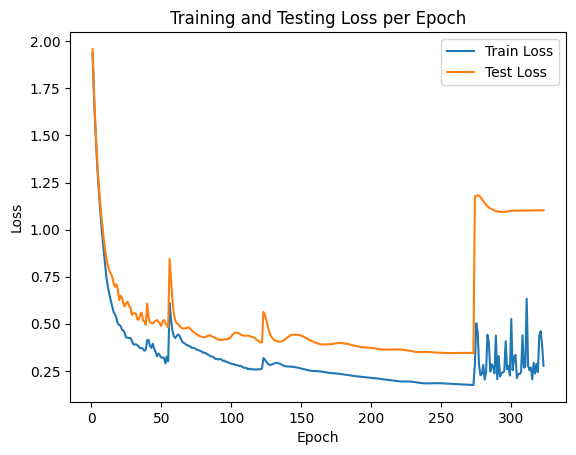

In [13]:
# Plot losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss per Epoch')
plt.legend()
plt.show()

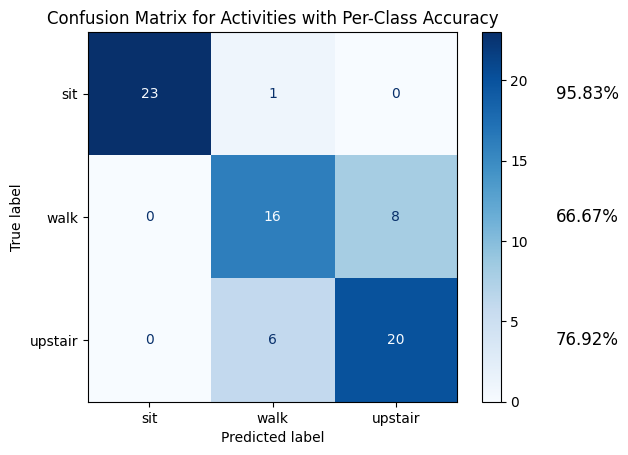

In [14]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Activities for the Confusion matrix
ACTIVITIES = ['sit', 'walk','upstair']

# Model evaluation (confusion matrix)
model.eval()
all_predictions = []
all_labels = []

# Loop through the test loader to collect predictions and true labels
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Compute the confusion matrix, explicitly specifying the labels
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2]) 

# Assuming conf_matrix and ACTIVITIES are already defined
class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)  # Compute per-class accuracy

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=ACTIVITIES)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Add per-class accuracy text
for i, activity in enumerate(ACTIVITIES):
    acc_text = f"{class_accuracies[i] * 100:.2f}%"
    ax.text(
        len(ACTIVITIES) + 0.3, i, acc_text, 
        fontsize=12, verticalalignment='center', color='black'
    )

plt.title("Confusion Matrix for Activities with Per-Class Accuracy")
plt.show()

In [14]:
import torch.nn.functional as F

model.eval()  # Set model to evaluation mode
incorrect_samples = []

with torch.no_grad():  # Disable gradient computation
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)  # Get raw logits
        probabilities = F.softmax(outputs, dim=1)  # Convert to probabilities
        predicted_labels = torch.argmax(probabilities, dim=1)  # Get predicted class
        confidence_scores = torch.max(probabilities, dim=1).values  # Get max confidence

        # Find incorrect predictions
        incorrect_indices = (predicted_labels != batch_y)
        for i in range(len(batch_y)):
            if incorrect_indices[i]:
                incorrect_samples.append({
                    "True Label": batch_y[i].item(),
                    "Predicted Label": predicted_labels[i].item(),
                    "Confidence": confidence_scores[i].item(),
                    "Probabilities": probabilities[i].tolist()
                })

# Print results
for sample in incorrect_samples:
    print(f"True Label: {sample['True Label']}, Predicted: {sample['Predicted Label']}, Confidence: {sample['Confidence']:.4f}")
    print(f"Full Probabilities: {sample['Probabilities']}")

True Label: 1, Predicted: 2, Confidence: 0.5632
Full Probabilities: [0.04549906402826309, 0.380174845457077, 0.5631895065307617, 0.0032607479952275753, 0.003766833571717143, 0.0018605184741318226, 0.0015481073642149568, 0.000700346368830651]
True Label: 1, Predicted: 2, Confidence: 0.6810
Full Probabilities: [0.011753139086067677, 0.30442631244659424, 0.6809886693954468, 0.0006740986718796194, 0.0012691640295088291, 0.0004664491571020335, 0.00032156932866200805, 0.00010061143984785303]
True Label: 2, Predicted: 1, Confidence: 0.5529
Full Probabilities: [0.0026117723900824785, 0.5528621673583984, 0.4438559114933014, 0.00019829421944450587, 0.00030244304798543453, 0.0001001448545139283, 5.4302101489156485e-05, 1.4893099432811141e-05]
True Label: 2, Predicted: 1, Confidence: 0.5486
Full Probabilities: [0.004549802280962467, 0.5485712885856628, 0.4460671842098236, 0.00025563352392055094, 0.00034394775866530836, 0.00012187402171548456, 7.234672375489026e-05, 1.8010583517025225e-05]
True Lab